In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -q "C:\Users\User\Desktop" -d /content/

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow_hub as hub
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [8]:
df=pd.read_csv("C:\\Users\\User\\Desktop\\Reviews.csv", encoding='latin-1', index_col=0)
df=df.loc[:,["Text","Score"]].dropna().reset_index(drop=True)
df.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [9]:
df.loc[df['Score'] <=2, 'Score'] = 0
df.loc[df['Score'] > 3, 'Score'] = 1
df.drop(df[df['Score']==3].index,inplace=True)
df["Score"].value_counts()

1    443777
0     82037
Name: Score, dtype: int64

Text(0.5, 1.0, 'Bar plot of sentiments')

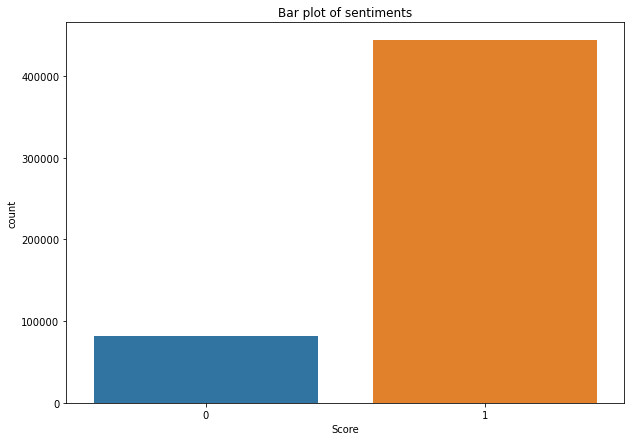

In [10]:
plt.figure(figsize = (10,7))
sns.countplot(df['Score'])
plt.title("Bar plot of sentiments")

In [11]:
df['len'] = df.Text.apply(lambda x: len(x.split()))
df['Text']=df['Text'].apply(lambda row : re.sub('<.*?>','',row))

In [12]:
df.head()

,Text,Score,len
0,I have bought several of the Vitality canned d...,1,48
1,Product arrived labeled as Jumbo Salted Peanut...,0,31
2,This is a confection that has been around a fe...,1,94
3,If you are looking for the secret ingredient i...,0,41
4,Great taffy at a great price. There was a wid...,1,27


In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['Text','len']],df.Score, test_size=0.2, random_state=42, stratify=df.Score)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(420651, 2) (420651,) (105163, 2) (105163,)


In [14]:
max_seq_length = 60
tf.keras.backend.clear_session()
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)

In [15]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 60)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 60)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 60)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 60, 768)]                 'input_mask[0][0]',         

In [16]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [17]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [18]:
!pip install bert-tensorflow==1.0.1
from bert import tokenization
tf.gfile = tf.io.gfile
tokenizer =tokenization.FullTokenizer(vocab_file,do_lower_case)

In [19]:
def bert_preprocess(sentence,tokenizer,max_seq_len=512):
    tokens=[]
    masks=[]
    segments=[]
    for word in sentence:
        word=tokenizer.tokenize(word)
        word=word[:max_seq_len-2]
        seq=["[CLS]"] + word + ["[SEP]"]
        token = tokenizer.convert_tokens_to_ids(seq)
        padding_tokens=token+[0]*(max_seq_len-len(token))
        mask=[1]*len(seq)
        masking=mask+[0]*(max_seq_len-len(token))
        segment=np.zeros(max_seq_length)
        
        tokens.append(padding_tokens)
        masks.append(masking)
        segments.append(segment)
    return np.array(tokens),np.array(masks),np.array(segments)

In [20]:
bert_model.input

[<KerasTensor: shape=(None, 60) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 60) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 60) dtype=int32 (created by layer 'segment_ids')>]

In [21]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [22]:
X_train_tokens, X_train_mask, X_train_segment=bert_preprocess(X_train.Text.values,tokenizer,60)
X_test_tokens, X_test_mask, X_test_segment=bert_preprocess(X_test.Text.values,tokenizer,60)

In [23]:
X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])
X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [24]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from sklearn.metrics import roc_auc_score
import datetime

In [25]:
auc=[]
val_auc=[]
class LossHistory(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.history={'val_accuracy': []}


    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
        auc_tr=(roc_auc_score(y_train,(self.model.predict(X_train_pooled_output))) )
        auc_test=(roc_auc_score (y_test, (self.model.predict(X_test_pooled_output) ) ) )
        print('\n  train_auc : ',auc_tr)
        print('  val_auc : ',auc_test)
        auc.append(auc_tr)
        val_auc.append(auc_test)
        loss=logs.get('loss')

In [26]:
filepath="model1_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

history_own = LossHistory()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',mode='max', patience=2, verbose=1)

In [27]:
input = Input(shape=[768,],name='input_layer')
dense1=Dense(400, activation='relu',name='dense_1')(input)
dense2=Dense(220, activation='relu',name='dense_2')(dense1)
dense3=Dense(40, activation='relu',name='dense_3')(dense2)
output=Dense(1, activation='sigmoid',name='dense_4')(dense3)
model1 = Model(inputs=input, outputs=output)
tf.keras.utils.plot_model(model1,"model_1.png",show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:
opt= tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=opt,loss=tf.keras.losses.BinaryCrossentropy(),metrics='accuracy')

In [29]:
X_test_pooled_output.shape

(105163, 768)

In [30]:
!rm -rf ./logs_model1/ 
tf.keras.backend.clear_session()
model1.fit(X_train_pooled_output,y_train,validation_data=(X_test_pooled_output,y_test),epochs=50,callbacks=[history_own])

Epoch 1/50


'rm' is not recognized as an internal or external command,
operable program or batch file.


13140/13146 [============================>.] - ETA: 0s - loss: 0.3001 - accuracy: 0.8738
  train_auc :  0.8997839160128778
  val_auc :  0.900593619015557
13146/13146 [==============================] - 31s 2ms/step - loss: 0.3001 - accuracy: 0.8739 - val_loss: 0.2678 - val_accuracy: 0.8877
Epoch 2/50
13118/13146 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.8844
  train_auc :  0.9047661185387328
  val_auc :  0.9053596375209573
13146/13146 [==============================] - 31s 2ms/step - loss: 0.2761 - accuracy: 0.8843 - val_loss: 0.2658 - val_accuracy: 0.8868
Epoch 3/50
13118/13146 [============================>.] - ETA: 0s - loss: 0.2700 - accuracy: 0.8870
  train_auc :  0.9075879053344822
  val_auc :  0.9079578924551447
13146/13146 [==============================] - 30s 2ms/step - loss: 0.2700 - accuracy: 0.8870 - val_loss: 0.2591 - val_accuracy: 0.8916
Epoch 4/50
13128/13146 [============================>.] - ETA: 0s - loss: 0.2665 - accuracy: 0.8884
  trai

13146/13146 [==============================] - ETA: 0s - loss: 0.2440 - accuracy: 0.8981
  train_auc :  0.9228453064410729
  val_auc :  0.9214407557263002
13146/13146 [==============================] - 31s 2ms/step - loss: 0.2440 - accuracy: 0.8981 - val_loss: 0.2409 - val_accuracy: 0.8994
Epoch 29/50
13118/13146 [============================>.] - ETA: 0s - loss: 0.2437 - accuracy: 0.8982
  train_auc :  0.9230591099803143
  val_auc :  0.9214960753325673
13146/13146 [==============================] - 31s 2ms/step - loss: 0.2436 - accuracy: 0.8982 - val_loss: 0.2407 - val_accuracy: 0.9001
Epoch 30/50
13127/13146 [============================>.] - ETA: 0s - loss: 0.2434 - accuracy: 0.8987
  train_auc :  0.9229090578445192
  val_auc :  0.9215648393388158
13146/13146 [==============================] - 31s 2ms/step - loss: 0.2434 - accuracy: 0.8987 - val_loss: 0.2444 - val_accuracy: 0.8962
Epoch 31/50
13116/13146 [============================>.] - ETA: 0s - loss: 0.2433 - accuracy: 0.8984
  

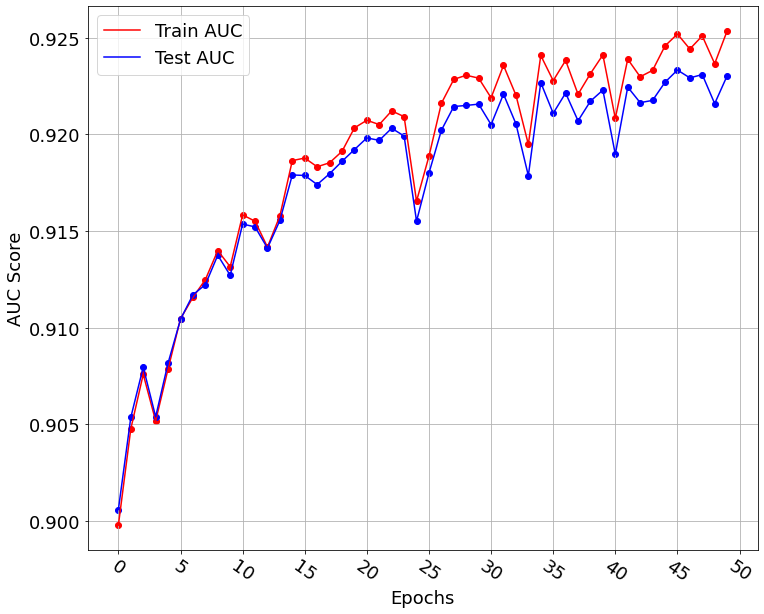

In [31]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,10))
plt.plot(np.arange(len(auc)),auc,color="red")
plt.plot(np.arange(len(auc)),val_auc,color='blue')
plt.scatter(np.arange(len(auc)),auc,color='red')
plt.scatter(np.arange(len(auc)),val_auc,color='blue')
plt.xticks(np.arange(0,len(auc)+1,5),rotation=-35)
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend(['Train AUC','Test AUC'])
plt.grid()
plt.show()